In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [ ]:
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
id2label = {0: "puppies", 1: "cats", 2: 'nature', 3: 'sports'}
label2id = {"puppies": 0, "cats": 1, 'nature': 2, 'sports': 3}

tokenizer = RobertaTokenizer.from_pretrained("facebook/data2vec-text-base")
text_model = AutoModelForSequenceClassification.from_pretrained("facebook/data2vec-text-base", num_labels=4, id2label=id2label, label2id=label2id)


Some weights of the model checkpoint at facebook/data2vec-text-base were not used when initializing Data2VecTextForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing Data2VecTextForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Data2VecTextForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Data2VecTextForSequenceClassification were not initialized from the model checkpoint at facebook/data2vec-text-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_

In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')

In [ ]:
from collections import defaultdict
train_dict = train_df.to_dict()
train_dict_dataset = defaultdict(list)
for key, values in train_dict.items():
    train_dict_dataset['label'].extend([key] * len(values.values()))
    train_dict_dataset['text'].extend(values.values())
train_dict_dataset['label'] = [label2id[label] for label in train_dict_dataset['label']]

In [ ]:
from datasets import Dataset
dataset = Dataset.from_dict(train_dict_dataset)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [ ]:
train_test = dataset.train_test_split(test_size=0.05)

In [ ]:
import pandas as pd
test_df = pd.read_csv('test.csv')

from collections import defaultdict
test_dict = test_df.to_dict()
test_dict_dataset = defaultdict(list)

for key, values in test_dict.items():
    test_dict_dataset['label'].extend([key] * len(values.values()))
    test_dict_dataset['text'].extend(values.values())
test_dict_dataset['label'] = [label2id[label] for label in test_dict_dataset['label']]

In [ ]:
test_dataset = Dataset.from_dict(test_dict_dataset)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=text_model,
    args=training_args,
    train_dataset=train_test["train"],
    eval_dataset=train_test["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.201200,0.961111
2,No log,0.072856,0.994444


TrainOutput(global_step=428, training_loss=0.47679751387266356, metrics={'train_runtime': 152.5801, 'train_samples_per_second': 44.829, 'train_steps_per_second': 2.805, 'total_flos': 410916958380864.0, 'train_loss': 0.47679751387266356, 'epoch': 2.0})

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

evaluator = Trainer(
    model=trainer.model,
    args=text_model,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

AttributeError: ignored

In [ ]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[ 2.8422744 , -0.6685616 , -1.1170981 , -1.1729615 ],
       [ 2.7810369 , -0.89562434, -0.69326776, -1.2622216 ],
       [ 2.8523848 , -0.6897541 , -1.1187077 , -1.1355428 ],
       ...,
       [-1.037355  , -1.0156827 ,  3.2244895 , -1.0978076 ],
       [-1.0548472 , -1.0921129 ,  3.2601418 , -1.0033985 ],
       [-1.0790247 , -1.0560912 ,  3.2554607 , -1.0228684 ]],
      dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
trainer.model(**tokenizer(test_dataset[0], return_tensors="pt"))

ValueError: ignored

In [ ]:
output['hidden_states'][-1].shape

torch.Size([1, 27, 768])

In [ ]:
vectors = []
labels = []
for i in range(len(test_dataset)):
  labels.append(id2label[test_dataset[i]['label']])
  tokenized_text = tokenizer(test_dataset[i]['text'], return_tensors="pt")
  input_ids = tokenized_text['input_ids'].to('cuda')
  attn_mask = tokenized_text['attention_mask'].to('cuda')
  output = text_model(input_ids = input_ids, attention_mask = attn_mask, output_hidden_states=True)
  vector = output['hidden_states'][-1][0,0,:]
  vectors.append(vector.cpu().detach().numpy())



In [ ]:
vectors = np.array(vectors)
len(labels)

400

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt

In [ ]:
def tsne_plot(vectors2, labels):
    "Creates and TSNE model and plots it"
    tsne_model = TSNE(perplexity=40, n_components=2,
                      init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(vectors2)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


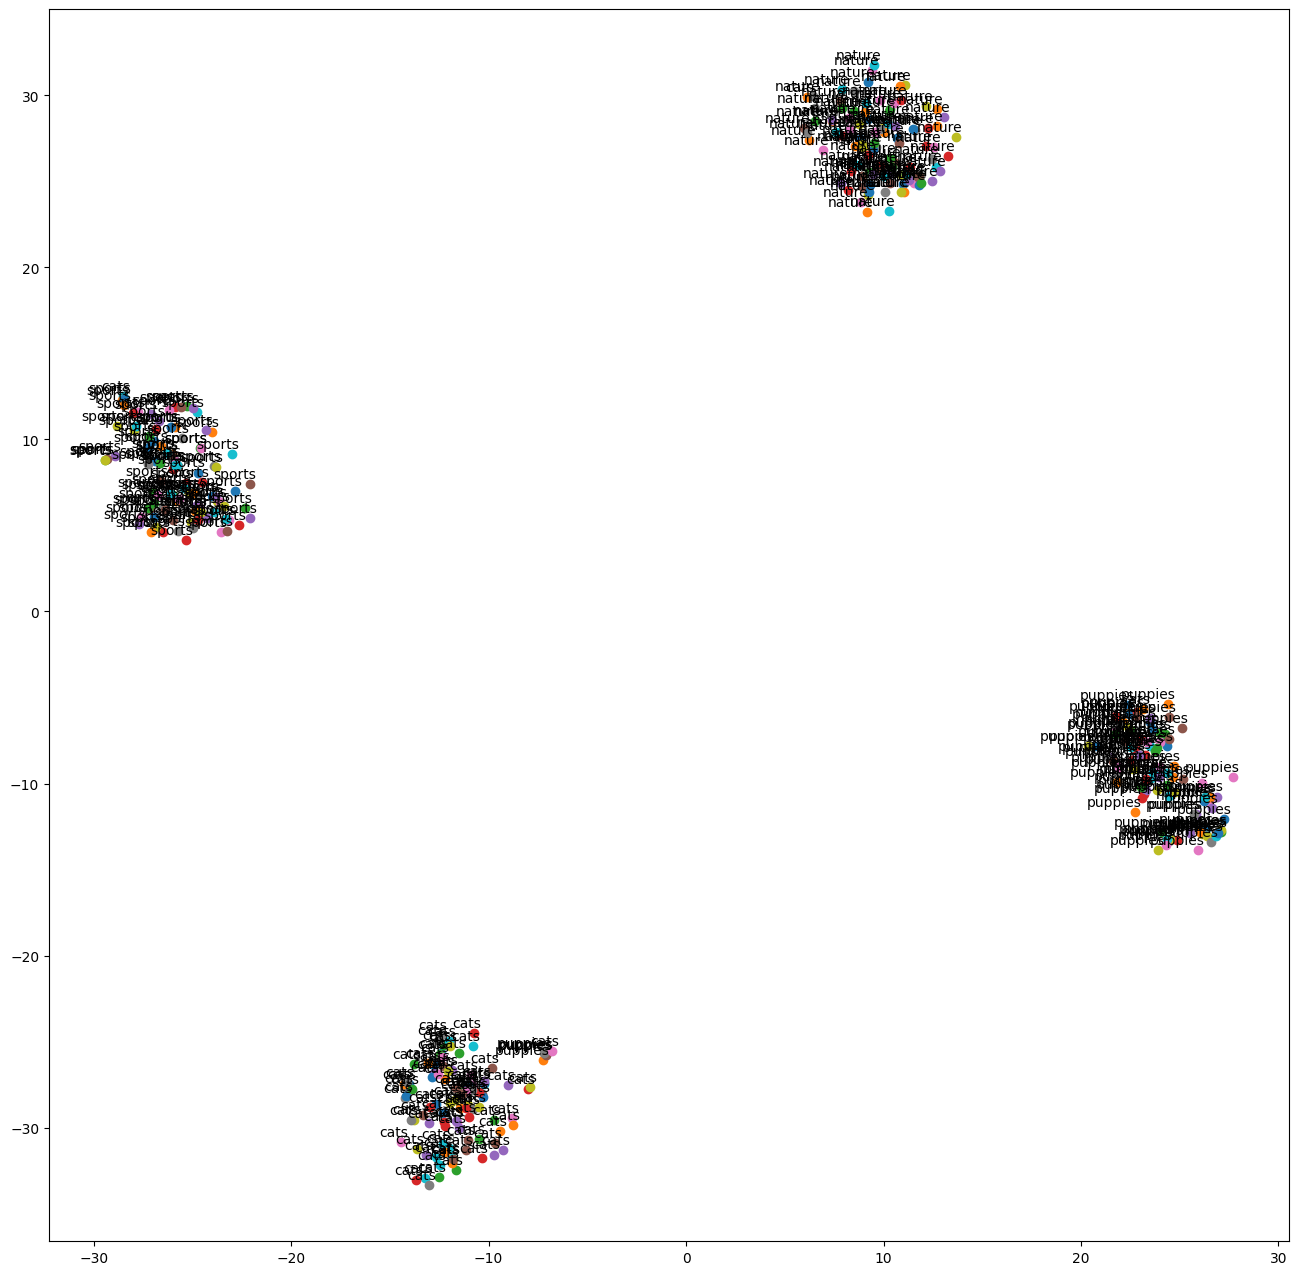

In [ ]:
tsne_plot(vectors, labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv my_awesome_model/ drive/MyDrive/IR_doc_model

In [ ]:
trainer

In [ ]:
trainer.checkpoint

AttributeError: ignored